# Recommender Systems

### Please make sure you have the following libraries - pandas, numpy, scipy, sklearn, seaborn, matplotlib

In [8]:
import pandas as pd
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import norm
from numpy import linalg as LA
from sklearn.metrics import roc_auc_score,roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import metrics
import sklearn
import seaborn as sns
from scipy import interp

# Loading data

In [9]:
#base
dataset_u1 = np.loadtxt("u1.base", dtype=np.int64) #user id | item id | rating | timestamp.

#test
dataset_u1test = np.loadtxt("u1.test", dtype=np.int64) #user id | item id | rating | timestamp.

In [10]:
#u1.base
mat_csr_items = csr_matrix((dataset_u1[:,2], (dataset_u1[:,1], dataset_u1[:,0])))
mat_csr_users = csr_matrix((dataset_u1[:,2], (dataset_u1[:,0], dataset_u1[:,1])))
mat_csc_items = mat_csr_users.tocsc()

mean_rank_per_item = mat_csr_items.mean(axis=1)

#u1.test
dataset_u1test.shape
mat_csr_test_users = csr_matrix((dataset_u1test[:, 2], (dataset_u1test[:, 0], dataset_u1test[:, 1])))
mat_csr_test_users.data[:] = 1

## Save the data into an external file

In [11]:
scipy.sparse.save_npz('mat_csr_items.npz', mat_csr_items)
scipy.sparse.save_npz('mat_csc_items.npz', mat_csc_items)
scipy.sparse.save_npz('mat_csr_test_users.npz', mat_csr_test_users)

# Similarity Matrix
#### 4 different similarity methods

In [12]:
def cosine_similarity(items_users_matrix): 

    similarity = items_users_matrix.dot(items_users_matrix.transpose())# all dot products
    root_square_mag = norm(items_users_matrix, axis=1)# norms - the square root over the sum of squares of the item elements
    inv_mag = 1.0 / root_square_mag# inverse of square_root_mag
    inv_mag[np.isinf(inv_mag)] = 0 # set the inverse magnitude to zero where it is inf
    cosine = (similarity.multiply(csr_matrix(inv_mag))).multiply(csr_matrix(inv_mag).transpose())
    scipy.sparse.save_npz('cosine_similarity.npz', cosine)


def adjusted_cosine_similarity(items_users_matrix):
    # the function uses only users that rated both items
    #calculate the averages of ranking of rated items
    sums = items_users_matrix.sum(axis=1).A1
    counts = np.diff(items_users_matrix.indptr)
    averages = 1.0*sums / counts

    items_users_matrix.data = items_users_matrix.data.astype(float)
    items_users_matrix.data -=np.repeat(averages, np.diff(items_users_matrix.indptr))#update the values of the matrix to be the difference between the averges and the original ranking 

    similarity = items_users_matrix.dot(items_users_matrix.transpose())# all dot products
    root_square_mag = norm(items_users_matrix, axis=1)# norms - the square root over the sum of squares of the item elements
    inv_mag = 1.0 / root_square_mag # inverse of square_root_ma
    inv_mag[np.isinf(inv_mag)] = 0 # set the inverse magnitude to zero where it is inf
    cosine = (similarity.multiply(csr_matrix(inv_mag))).multiply(csr_matrix(inv_mag).transpose()) # cosine similarity
    scipy.sparse.save_npz('adjusted_cosine_similarity.npz', cosine)



def dice_similarity_sklearn(items_users_matrix):
    items_users_matrix.data[:] = 1
    items_users_matrix=items_users_matrix.toarray()
    dice_distances = sklearn.metrics.pairwise.pairwise_distances(items_users_matrix, metric='dice')
    dice_similarities = 1 - dice_distances
    dice_similarities = csr_matrix(dice_similarities)
    dice_similarities.data = np.nan_to_num(dice_similarities.data)
    dice_similarities.eliminate_zeros()
    scipy.sparse.save_npz('dice_similarity_sklearn.npz', dice_similarities)


def jaccard_similarity_sklearn(items_users_matrix):
    items_users_matrix.data[:] = 1
    items_users_matrix=items_users_matrix.toarray()
    jaccard_distances = sklearn.metrics.pairwise.pairwise_distances(items_users_matrix, metric='jaccard')
    jaccard_similarities = 1 - jaccard_distances
    jaccard_similarities = csr_matrix(jaccard_similarities)
    jaccard_similarities.data = np.nan_to_num(jaccard_similarities.data)
    jaccard_similarities.eliminate_zeros()
    scipy.sparse.save_npz('jaccard_similarity_sklearn.npz', jaccard_similarities)



In [13]:
def claculate_sim(sim_fun=cosine_similarity):
    mat_csr_items = scipy.sparse.load_npz('mat_csr_items.npz')#reading the sparse matrix from an external npz file
    return sim_fun(mat_csr_items)    

### Calulates the similarity matrix for each similarity 

In [14]:
list_sim_fun = [cosine_similarity , adjusted_cosine_similarity, dice_similarity_sklearn, jaccard_similarity_sklearn]
list_sim_fun_str = ['cosine_similarity' , 'adjusted_cosine_similarity', 'dice_similarity_sklearn', 'jaccard_similarity_sklearn']

list_sim_results = []
for i,similarity in enumerate(list_sim_fun):
    claculate_sim(similarity)
    list_sim_results.append(scipy.sparse.load_npz(str(list_sim_fun_str[i])+'.npz'))#reading the sparse matrices from an external npz files

C:\Users\or\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """
C:\Users\or\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()
C:\Users\or\Anaconda2\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in divide
C:\Users\or\Anaconda2\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


# Prediction Function

In [15]:
def rating_prediction(user_id, item_id, k, i_i_sim):
    user_ind = user_id - 1
    item_ind = item_id - 1

    indices_sim_items = i_i_sim.indices #the indices of item to item similrity with nonzero value

    user_ranking = mat_csr_users.getrow(user_id) #get the user ranking vector
    item_i_sim = i_i_sim.getrow(item_id) #get the simlarity of item to all other items

    index_items_user_rated = user_ranking.indices  # the items id of  the items the user rated
    index_items_rated = item_i_sim.indices  # the items id of the items which their similarity is grater than 0

    intersect_items_rated_user_rated = np.intersect1d(index_items_rated, index_items_user_rated) #the indices of items that were rated (their similarity to item is bigger than 1) and that the user rated 
    sim_rated = item_i_sim[0, intersect_items_rated_user_rated] #similarity of item to items that were rated and that the user rate
    ranking_rated = user_ranking[0, intersect_items_rated_user_rated] #the ranking of the items user rated and that was rated
    sim_rated.data = sim_rated.data.astype(float)
    array_sim_rated_data = np.array(sim_rated.data)
    
    if array_sim_rated_data.size!=0: #if there are similar items to current item
        # Note: here we take k largest and not k+1 because the user did not rate yet the item we would like to predict
        # thus he will not be in the list
        if len(intersect_items_rated_user_rated) < k: #if there are less interset_items than k 
            k = len(intersect_items_rated_user_rated) #set k to be the number of interset_items

        similarity_thresh = min(np.sort(array_sim_rated_data, axis=None)[-k:]) #
        mask = np.where(array_sim_rated_data < similarity_thresh) #the indiced of items where the similarity is smaller than the threshold 
        sim_rated.data[mask] = 0 #set value zero where the similarity is smaller than the threshold 

    denominator = sim_rated.sum()# the denominator value is the sum of the similarities only for the items that were rated by the user

    if denominator != 0:
        rate_prediction = ((1.0 * sim_rated.dot(ranking_rated.transpose())) / denominator).data[0]
    else:
        item_ranking = mat_csr_items.getrow(item_id)
        if item_ranking.data.size!=0: #if there is at least one ranking for the item
            rate_prediction = np.mean(item_ranking.data) #the rate will be the average ranking of all users who rated the items
        else: #there arnt ranking for the item
            if user_ranking.data.size!=0: # if there are no user ratings for the item
                rate_prediction = np.mean(user_ranking.data) #predict the average rating of the user
            else: #there arnt ranking for the item and the user never rated before
                rate_prediction = 3 #predict the average rank
    return rate_prediction

# Evaluate the system:
This will not run as an online function. This will help us evaluate our model.

In [16]:
list_MAE = []
list_MAE_per_sim=[]
for i,sim_measure in enumerate(list_sim_results):
    list_MAE=[]
    for k in [10, 20, 50, 100]:
        MAE = 0
        for user_item in dataset_u1test: #for each user in test
            p = rating_prediction(user_item[0], user_item[1], k, sim_measure) #predict the rating
            MAE += abs(p - user_item[2])
        MAE /= dataset_u1test.shape[0]
        list_MAE.append(MAE) #MAE of each k for current similarity
    list_MAE_per_sim.append(list_MAE)

### The MAE results for different similarities and differnet Ks

cosine_similarity
        MAE    k
0  0.770918   10
1  0.776141   20
2  0.795308   50
3  0.810617  100
adjusted_cosine_similarity
        MAE    k
0  0.808787   10
1  0.798694   20
2  0.839975   50
3  1.439827  100
dice_similarity
        MAE    k
0  0.759561   10
1  0.763367   20
2  0.785566   50
3  0.803804  100
jaccard_similarity
        MAE    k
0  0.758883   10
1  0.762218   20
2  0.783405   50
3  0.800725  100


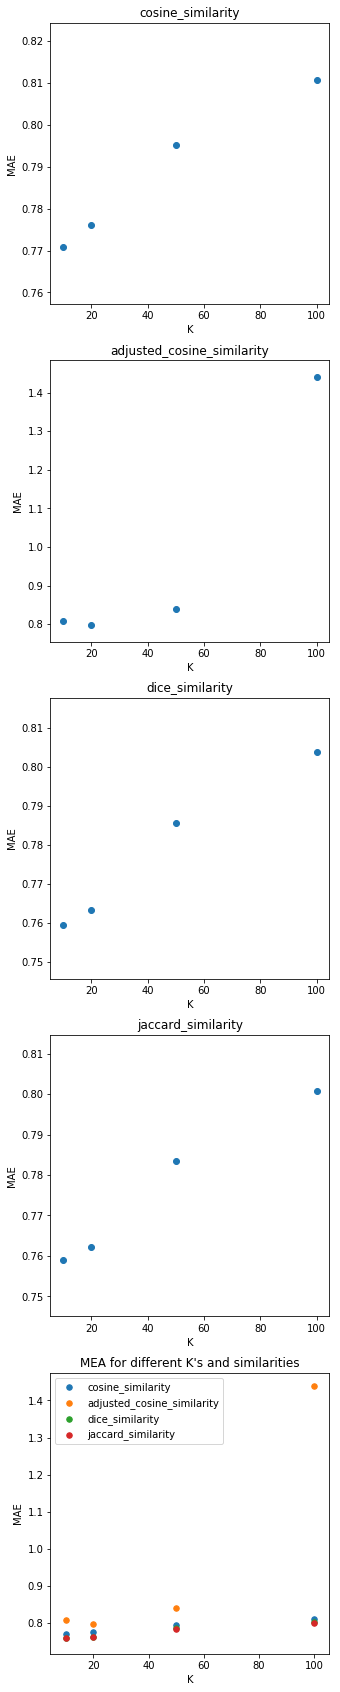

In [17]:
fig, axes = plt.subplots(5, 1,figsize=(5, 30))
for i,sim_measure in enumerate(["cosine_similarity" , "adjusted_cosine_similarity", "dice_similarity", "jaccard_similarity"]):
    df = pd.DataFrame({"k":[10, 20, 50, 100],"MAE":list_MAE_per_sim[i]})
    print sim_measure
    print df
    axes[i].scatter(df["k"], df["MAE"])
    axes[i].set_title(sim_measure)
    axes[i].set_xlabel('K')
    axes[i].set_ylabel('MAE')
    axes[4].scatter(df["k"], df["MAE"], label=sim_measure, s=30)
axes[4].set_title("MEA for different K's and similarities")    
axes[4].set_xlabel('K')
axes[4].set_ylabel('MAE')
axes[4].legend()
plt.show()

# Explanation - different MAE for differnet Ks
For all the similarities we can see that the bigger the K is the bigger the MAE is.
K represents the number of neighboors that have the highest similarity with the item.

When the model takes into consideration "too many" neighboors, it turns out that some neighboors are not actually very similar to the original item.
Thus the predicted result is biased, and can lead to greater errors.
If a certain item has multiple simillar neighboor itmes, a big K can lead to a better result (because many **similar** neighbors will affect). When the item has very few simillar neighboor itmes, a big K can lead to a bad result (because many **different** neighbors will affect).

If we want to improve this KNN inspired algorithm we should check that the K nearest neighboors actually meet a certain similarity threshold. The first item out of the K that doesn't meet the threshold will not be included.



The choice of the k nearest neighbors for the neighborhood formation results in a tradeoff: a very small k leads to a few candidate items that can be recommended because there are not a lot of neighbors to support the predictions. In contrast, a very large k impacts precision as the particularities of user's preferences can be blunted due to the large neighborhood size. In most related works k has been set to be in the range of values from 10 to 100, where the optimum k also depends on data characteristics such as sparsity.

The lowset MAE score was recieved for jaccard_similarity with k=10.

for the the range of k=(10,20,50) all 4 similarities achieved a simillar MAE score with a difference which is no bigger than 0.1. However, only for k=100 the MAE of adjusted cosine similarity was higher by about 0.6 from the other similarities.  

In conclusion based on the result we would recommend using the jaccard similarity as it got the lowest MAE score for all K's.

# Rankings:
skiping the rating prediction and calculating directly the items ranking for each user

In [18]:
'''check here 
The index and the first column items_id have to be different.
We found out that we get the same values in df.index and df.items_id so it might be a problem'''
def recomended_items(user_id, k ,i_i_sim, h):
    user_ind = user_id - 1
    user_rating = mat_csr_users.getrow(user_id) #get the user rating from the sparse matrix

    index_items_user_not_rated = sparse.find(user_rating==0)[1] # all items id that the user didnt rate
    index_items_user_rated = user_rating.indices # all items id that the user rate
    
    sim_notrated_rated = i_i_sim[index_items_user_not_rated][:,index_items_user_rated]#get the similarity values between the unrated and rated items
    new_index = np.arange(0,index_items_user_not_rated.shape[0]+1)
    df_indexes = pd.DataFrame(index_items_user_not_rated, columns=["items_id"])#dataframe storing the items 
    
    if sim_notrated_rated.size==0: # if there weren't similar items for the items the user didnt rank - the user rank nothing
        index_sorted_by_mean = np.argsort(-mean_rank_per_item, axis=1) #indices of items sorted by items mean rank
        recommended_items_index = index_sorted_by_mean[:h] #the top h items
        df_indexes["rate_prediction"] = np.zeros(index_items_user_not_rated.shape[0])#the prediction for all notrated items is zeros.
        
    else: # if there awere similar items for the item the user didn't rate
        if len(index_items_user_rated)<k:#if the number of rated items by the user is smaller than k
            k = len(index_items_user_rated)#set k to be the number of rated items by the user
        array_sim_notrated_rated = sim_notrated_rated.toarray()
        items_index_soreted_sim = np.argsort(-array_sim_notrated_rated, axis=1)[:, :k] #for each unrated item - get the k most similar items the user rated
        sum_sim_not_rated = np.zeros(array_sim_notrated_rated.shape[0]) #initialize the sum for each unrated item to zero

        for unrated in range(array_sim_notrated_rated.shape[0]):#for each unrated item
            sum_sim_not_rated[unrated] += np.sum(array_sim_notrated_rated[unrated, items_index_soreted_sim[unrated]]) #sum of cosine similarity between unrated and rated items

        df_indexes["rate_prediction"] = sum_sim_not_rated #create a column in a dataframe of rate prediction
        recommended_items_index = np.argsort(-sum_sim_not_rated)[:h] #the indices of the top h unrated items (sorted by the rate prediction)
        recommended_items_index = df_indexes.loc[recommended_items_index]["items_id"].values.tolist() #return the original indices of the top h items we recommend to the user.
            
    return recommended_items_index, df_indexes

# Evaluate the system using average AUC

C:\Users\or\Anaconda2\lib\site-packages\scipy\sparse\compressed.py:214: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


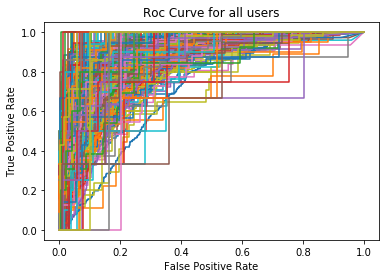

0.894236266765


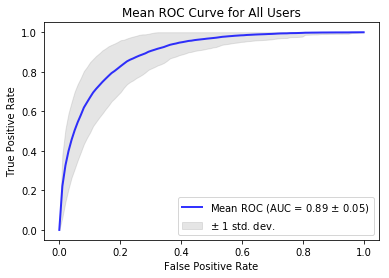

In [19]:
mat_csr_test_users = scipy.sparse.load_npz('mat_csr_test_users.npz') #reading the sparse matrix from an external npz file

#variables for computing mean roc curve
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
        
auc_scores = []
for user_id in range(1, mat_csr_test_users.shape[0]):  # for each user in test
    user_test_scores = mat_csr_test_users.getrow(user_id) #get the current user row in sparse matrix
    rec_items, df_pred = recomended_items(user_id, 2, list_sim_results[0],2)  # get the the recommended items+df of the ranking for all items from u1.base
    df_pred.sort_values('items_id', inplace=True)  # sort the df by items id
    df_pred.index = df_pred.items_id  # set the df index to as the item id
    index_items_user_rated_test = user_test_scores.indices  # all items id that the user rated

    if not index_items_user_rated_test.size == 0: #if the user rank at least one item in test
        df_true = pd.DataFrame({"is_rated": np.zeros(mat_csr_items.shape[0])}) 
        df_test = df_true.copy()
        df_true[df_true.index.isin(index_items_user_rated_test)] = 1 #set 1 for items the user rated in the test
        df_test["items_id"] = df_test.index 
        df_merge_test = df_test.merge(df_pred, on="items_id", how="left") #left merge the df of all items with df of only unrated items in u1.base but rated in u1.test
        df_merge_test.fillna(0, inplace=True) #set zero to all items that are not in test set
        y_score = df_merge_test["rate_prediction"].values
        y_true = df_true["is_rated"].values
        auc_s = metrics.roc_auc_score(y_true, y_score) #calculate the auc score
        auc_scores.append(auc_s) #append the auc to the list of auc for all users
        fpr, tpr, thresh = metrics.roc_curve(y_true, y_score)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        
        #create a plot of roc curve for all users 
        plt.plot(fpr,tpr, label="auc="+str(auc_s))
        plt.title('Roc Curve for all users')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
plt.show()                 
avg_auc = np.mean(auc_scores) #calculate the mean of all users auc
print avg_auc
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve for All Users')
plt.legend(loc="lower right")
plt.show()